# Postprocessing

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
#%load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

## Load run + general diagnostics

In [2]:
pwd

'/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/3C66B/UL'

In [3]:
with h5py.File('/scratch/na00078/QuickCW_targeted_runs/results/3C66B_UL_numba_correct_outfile.h5', 'r') as f:
    print(list(f.keys()))
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

['T-ladder', 'acc_fraction', 'fisher_diag', 'log_likelihood', 'par_names', 'samples_cold']
(100000000, 8)
(1, 100000000)


hamp [7.7321951e-12 6.0185174e-16 6.1826126e-16 ... 4.7144229e-16 4.4106117e-17
 2.3213968e-18]
freq [6.3268914e-08 6.3268914e-08 6.3268914e-08 ... 6.4302029e-08 6.4302029e-08
 6.4302029e-08]
mc [6.2758458e+08 6.2758458e+08 6.2758458e+08 ... 4.1453878e+09 4.1453878e+09
 4.1453878e+09]


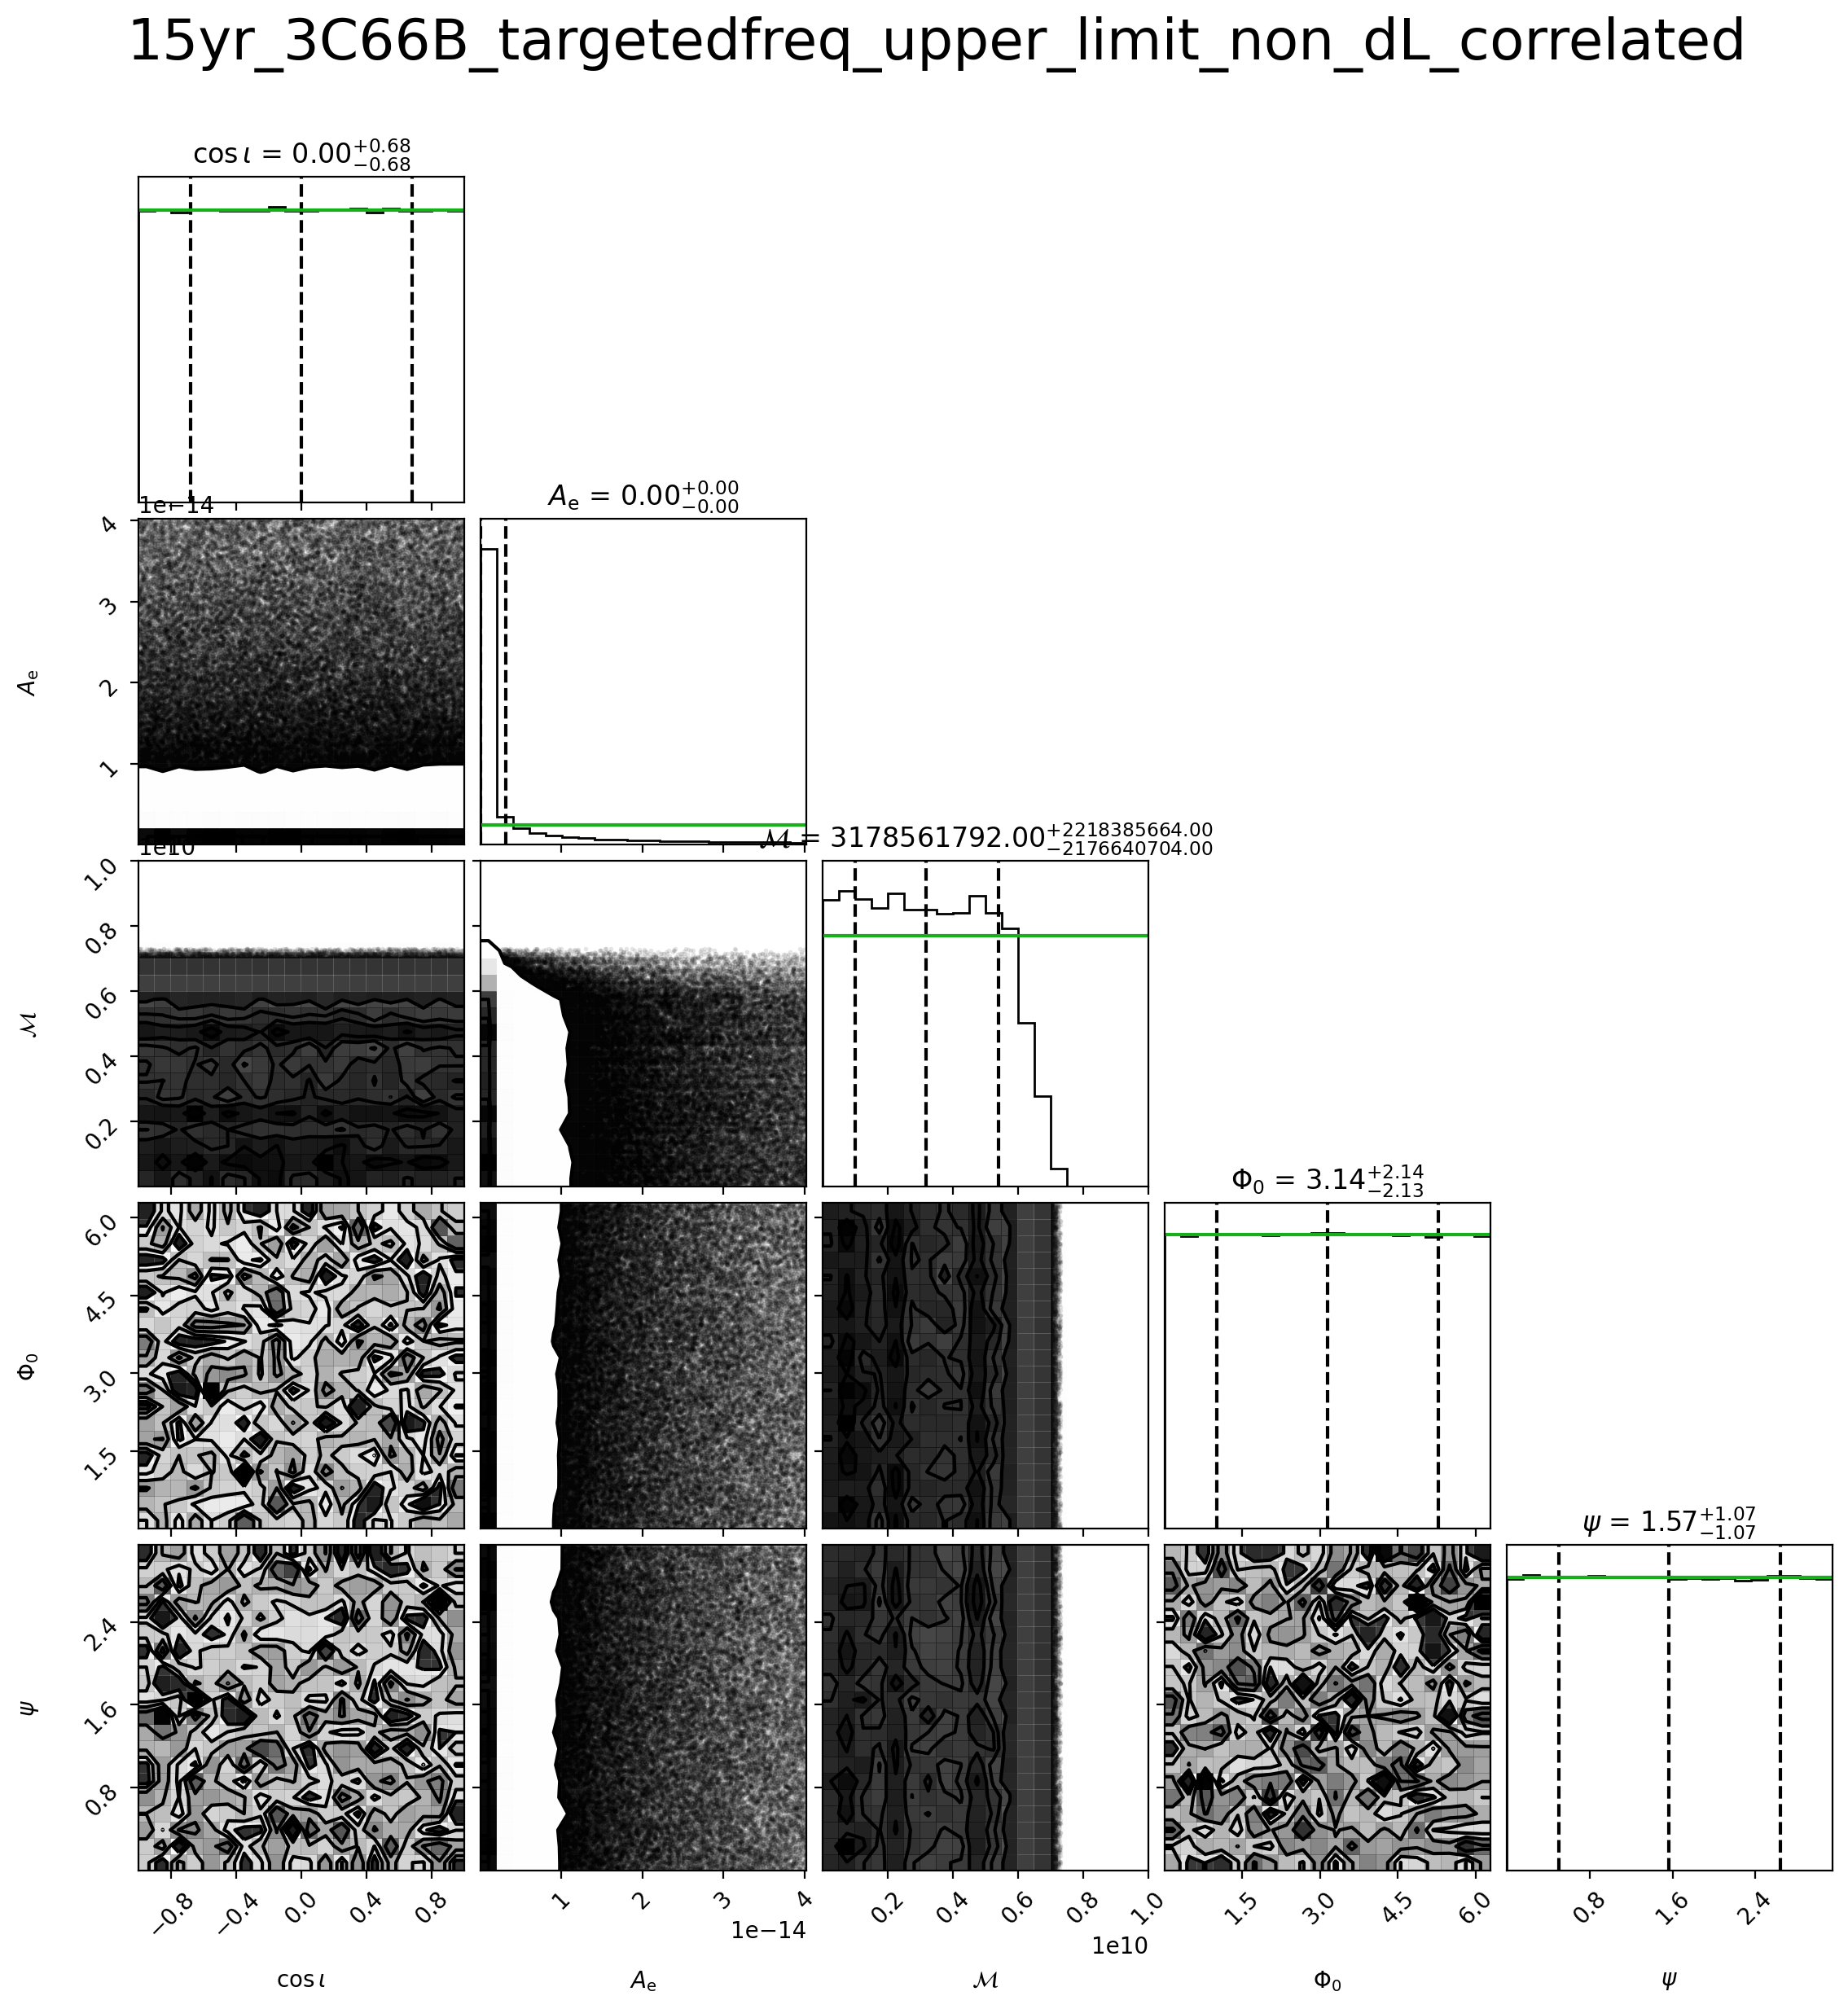

In [4]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
#Without dL
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$A_{\rm e}$", r"$\cal M$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 100

#set ranges
ranges = [(-1,1), (1.3175879e-18,4.0176795e-14), (10**6.6,10**10), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)
'''
log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))
'''
samplescold_UL = np.vstack((
                          samples_cold[0][burnin::thin,1],
                          np.power(10,(samples_cold[0][burnin::thin,4])),
                          10**samples_cold[0][burnin::thin,5],
                          samples_cold[0][burnin::thin,6],
                          samples_cold[0][burnin::thin,7])).T


fig = corner.corner(samplescold_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(10**-18, 10**-11)     #amplitude
        ax.plot(Xs,Xs*0+(1/(- 1.3102823e-18 + 4.2492482e-14)), color="xkcd:green")
        #ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(10**6.6, 10**10)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs,Xs*0+(1/((10**9.86) - (10**6.60))), color="xkcd:green")
        #ax.plot(Xs, 10**(Xs*0+1/3), color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_non_dL_correlated', fontsize = 25,y=1.05);

In [ ]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"${\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]

#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (10**6.6,10**10), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
'''
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
'''
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("Sample length", len(samples2plot))
print("Original Sample length", len(samples_cold))
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_UL = np.vstack((samples2plot[d_L_mask,0],
                          samples2plot[d_L_mask,1],
                          samples2plot[d_L_mask,2],
                          samples2plot[d_L_mask,3],
                          samples2plot[d_L_mask,4],
                          10**samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7],
                            samples2plot[d_L_mask,8])).T

print(samples2plot[d_L_mask,8])
print("UL MC",10**samples2plot[d_L_mask,5])
print("UL shape",len(samples2plot_UL))
print("original",len(samples2plot[d_L_mask, :]))
fig = corner.corner(samples2plot_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_dL_85.8_Correlated', fontsize = 25);

In [ ]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$A_{\rm e}$", r"$\cal M$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (-18,-14), (6.6,10), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_UL = np.vstack((
                          samples2plot[d_L_mask,1],
                          samples2plot[d_L_mask,4],
                          samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7])).T


fig = corner.corner(samples2plot_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)     #amplitude
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(6.6, 10)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_dL_85.8_Correlated_log', fontsize = 25,y=1.05);

In [ ]:
Xs = np.linspace(6.6, 10)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
ax.plot(10**Xs, 10**Xs*0+1/3, color="xkcd:green")
print(10**Xs)
print(10**(Xs*0+1/3))

In [ ]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$A_{\rm e}$", r"$\cal M$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e7)
thin = 1

#set ranges
ranges = [(-1,1), (1.3175879e-18,4.0176795e-14), (10**6.6,10**10), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
target_d_L = 85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_UL = np.vstack((
                          samples2plot[d_L_mask,1],
                          np.power(10,(samples2plot[d_L_mask,4])),
                          10**samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7])).T


fig = corner.corner(samples2plot_UL,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(10**-18, 10**-11)     #amplitude
        ax.plot(Xs,Xs*0+(1/(- 1.3102823e-18 + 4.2492482e-14)), color="xkcd:green")
        #ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(10**6.6, 10**10)
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs,Xs*0+(1/((10**9.86) - (10**6.60))), color="xkcd:green")
        #ax.plot(Xs, 10**(Xs*0+1/3), color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_3C66B_targetedfreq_upper_limit_dL_85.8_Correlated', fontsize = 25,y=1.05);

In [ ]:
'''#corner plot of parameters common to all pulsars UNIFORM PRIOR

corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$"]


#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (np.log10(3.5e-9),-7), (-18,-11), (7,12), (0,2*np.pi), (0,np.pi) ]

#set burnin and thinning
burnin = 10000000
thin = 1

#truth = [xxx[key] for key in par_keys]
fig = corner.corner(samples_cold[0][burnin::thin,corner_mask], labels=labels, show_titles=True, range=ranges, hist_kwargs={"density":True})# quantiles=[0.16, 0.5, 0.84],
                    #truths=truth

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        ax.plot(Xs, Xs*0+1/(-7-np.log10(3.5e-9)), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(7, 12)
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('3C66B_targetedfreq_detection_non_dL_correlated', fontsize = 25);
'''

In [ ]:
#TRACE PLOTS!!!!!!!

title = ["gw cos_theta", "cos_inc","gw phi","log10 fGW","log10 h","log10 Mc","phase","psi","log10 dL"]

j=-1
row = 3
column = 3
fig, axs = plt.subplots(row, column,figsize=(30,20))#, dpi=80,squeeze=False)
fig.tight_layout(h_pad=3,w_pad=2)
#axs = plt.gca()
for i in range(len(title)): 
    if i%3 == 0:
        j+=1
    #print(j,i)
    axs[j, i%3].plot(d_L_mask, samples2plot[d_L_mask,i])#, ls='', marker='.')
    #axs[j, i%4].ylabel("prior value")
    #axs[j, i%4].xlabel("samples")
    #axs[j, i%4].axhline(xxx[par], ls='--')
    axs[j, i%3].set_title(title[i])
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[1, i+1].plot(samples_cold[0][::,i+1], ls='', marker='.')

fig.suptitle('3C66B UL dL_constrained trace plots', y=1.05)
plt.subplots_adjust()

#display subplots 
#plt.show()
#plt.savefig("/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/NGC3115/detect/NGC3115_pulsar_trace_plots2.png",dpi='figure',bbox_inches="tight")
#print('done')


# SD BF

In [ ]:
logAmin_dL = np.min(np.power(10,samples2plot[d_L_mask,4]))
logAmax_dL = np.max(np.power(10,samples2plot[d_L_mask,4]))
print(logAmin_dL)
print(logAmax_dL)
print(np.log10(logAmin_dL))
print(np.log10(logAmax_dL))
print(len(samples2plot[d_L_mask,4]))

plt.hist(np.power(10,samples2plot[d_L_mask,4]), bins=20, density=True)
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.title("3C66B upper limit A histogram d_L correlated")
plt.show()
print(np.power(10,samples2plot[d_L_mask,4]))
print(10**samples2plot[d_L_mask,5])

In [ ]:
#dL Mc Upper limit

logMcmin_dL = np.min(samples2plot[d_L_mask,5])
logMcmax_dL = np.max(samples2plot[d_L_mask,5])

print(logMcmin_dL)
print(logMcmax_dL)
print(samples2plot[d_L_mask,5])
print(np.power(10,samples2plot[d_L_mask,5]))

plt.hist(np.power(10,samples2plot[d_L_mask,5]), bins=20, density=True,color='green')
plt.axvline(x = 1120071680.0,color='black',label= "15yr Upper Limit = 1.12e+09")
plt.axvline(x = 1.34e+09,color='red',label= "12.5yr Upper Limit = 1.34e+09 ")
plt.hlines(1/((10**logMcmax_dL) - (10**logMcmin_dL)),10**logMcmin_dL,10**logMcmax_dL, color='blue')
plt.title("3C66B Upper Limit Mc histogram (with dL masking)",y=1.05)
plt.xlabel("Mc")
plt.ylabel("Posterior")
plt.legend()
plt.show()

x = np.quantile(np.power(10,samples2plot[d_L_mask,5]), 0.95)
print("95% UL is",x)
print(np.log10(x))
print("values", 1/((10**logMcmax_dL) - (10**logMcmin_dL)))

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
print (10**samples2plot[d_L_mask,5])

In [ ]:
Xs = (np.linspace(10**7, 10**10))
print((Xs*0+1/3)*10**9)
plt.plot(Xs, (Xs*0+1/3)*10**9, color="xkcd:green")

In [ ]:
#logAmin_dL = np.min(samples2plot[d_L_mask,4])
#logAmax_dL = np.max(samples2plot[d_L_mask,4])
#print(logAmin_dL)
#print(len(samples2plot[d_L_mask,4]))

label = ['log10_hmin = -18.56 or log10_Mcmin = 6.6','dL constained', 'non-dL constained', 'samples removed in dL masking',]

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hist(samples_cold[0][::10,4], bins=20, density=True,color = 'red',alpha=0.35)
plt.hist(samples2plot[merged_non_dL,4], bins=20, density=True,color = 'green',alpha=0.25)
plt.axvline(x = -18.56,color='k', linestyle='dashed', linewidth=1)
#plt.hist(samples2plot[not_d_L_mask_2,4], bins=20, density=True,color = 'green',alpha=0.25)
#plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')

plt.legend(label,bbox_to_anchor=(1, 1), loc='upper left')
plt.title("3C66B log10A posterior with and without dL masking")
plt.show()

In [ ]:
#d_L correlated SD BF
logamins = np.linspace(logAmin_dL, -15, 100)
BF_arr = []
BF_err_arr = []

from enterprise_extensions import model_utils
for logamin in logamins:
    BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmin=logamin, logAmax=-11)
    BF_arr.append(BF)
    BF_err_arr.append(BF_err)

plt.errorbar(logamins, BF_arr, yerr=BF_err_arr, fmt='o')
plt.xlabel('logAmin')
plt.ylabel("log10(BF)")
plt.title("3C66B BF with error bars (d_L correlated)")
plt.show()

In [ ]:
print(BF_arr[0:10])

In [ ]:
print(BF_err_arr[0:10])

In [ ]:
#Non d_L correlated SD BF
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

In [ ]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmin = -17.3, logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

In [ ]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][int(1e7) + d_L_mask,4], logAmin= -17.3,logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)
plt.plot(samples_cold[0][::10,4])
plt.show()

In [ ]:
#Non d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)
plt.plot(samples_cold[0][::10,4])
plt.show()

In [ ]:
print(samples_cold.shape)
print(d_L_mask)
plt.plot(samples_cold[0][int(1e7) + d_L_mask,4])
plt.show()
sample1 = samples_cold[0][int(1e7):]
plt.plot(sample1[d_L_mask,4])
plt.show()
plt.hist(sample1[d_L_mask,4], bins=20)
plt.show()

In [ ]:
'''#All wrong
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-14.6)
print('log10A BF = ', BF, " +- ", BF_err)

MCBF,MCBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,5], logAmin =7.33, logAmax= 8.65)
print('Mc BF = ', MCBF, " +- ", MCBF_err)

freqBF,freqBF_err =model_utils.bayes_fac(samples = samples_cold[0][::10,3], logAmin = -7.25 ,logAmax=-7.2)
print('freq BF = ', freqBF, " +- ", freqBF_err)
'''

In [ ]:
'''
f_min = 1e-9
f_max = 3e-7
print(f_min, f_max)

n_bins = 45#20#50

fbins = np.linspace(np.log10(f_min), np.log10(f_max), n_bins+1)
print(10**fbins[11], 10**fbins[12])

#set burnin and thinning
#burnin = 10_000
burnin = 100_000
thin = 1

log10_f = samples_cold[0][burnin::thin,3]
log10_A = samples_cold[0][burnin::thin,4]

"""n_bins = 50
#fmin = 10**(-8.704)
#fmax = 10**(-7.6)
fmin = -8.704
fmax = -7.6
fbins = np.linspace(fmin, fmax, n_bins+1)
print(fbins)
BFs = np.zeros(n_bins)"""

n_h_bin = 50
n_h_bin4err = 10
bins = np.linspace(-18,-11, n_h_bin)
#bins = np.linspace(-18,-11, 20)
prior_dens = 1/7.0

matplotlib.rcParams.update({'font.size': 12})

BFs = np.zeros(n_bins)
BF_errs = np.zeros(n_bins)
for i in range(n_bins):
    #f_mask = np.where((10**log10_f>fbins[i]) & (10**log10_f<fbins[i+1]))
    f_mask = np.where((log10_f>fbins[i]) & (log10_f<fbins[i+1]))
    hist = plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                   color='xkcd:black', alpha=0.0)
    BFs[i] = prior_dens/hist[0][0]
    
    #h_autocorr = emcee.autocorr.integrated_time(log10_A[f_mask], c=10, quiet=True)
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size/h_autocorr
    #N_eff = log10_A[f_mask].size/h_autocorr
    #N_eff = np.where((log10_A[f_mask]>bins[0]) &  (log10_A[f_mask]<bins[1]))[0].size
    #print(h_autocorr, log10_A[f_mask].size, N_eff)
    #BF_errs[i] = BFs[i]/np.sqrt(N_eff)
    
    BF_errs[i] = np.std(prior_dens/hist[0][:n_h_bin4err])
    
    if BFs[i]>250.0 and BFs[i]<np.inf:
        plt.hist(log10_A[f_mask], bins=bins, histtype='step', density=True,
                 label="{0:.2f} nHz - {1:.2f} nHz: BF={2:.1f}".format(10**fbins[i]*1e9,
                                                                      10**fbins[i+1]*1e9,
                                                                      BFs[i]),
                 alpha=1.0)
        plt.gca().axhline(prior_dens/(BFs[i]+BF_errs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]))
        plt.gca().axhline(prior_dens/(BFs[i]-BF_errs[i]))
        



plt.legend(loc=1, bbox_to_anchor=(1,0))
plt.yscale('log')
plt.gca().axhline(prior_dens, ls='--', color='xkcd:green')
    
print(BFs)  
'''

# SkyMap Check

In [ ]:
'''
#Figure 1a of Mingarelli + 2017
import astropy.constants as c
from astropy.coordinates import SkyCoord

RA_ra = np.mean(samples2plot[::,2])
DEC_ra= np.mean(np.pi/2-np.arccos(samples2plot[::,0]))

RA = RA_ra-np.pi
DEC = DEC_ra-np.pi/2

print(RA,DEC)


c = SkyCoord(ra = '16h44m52.7s', dec = '+43d07m52.9s')

RA_expect = c.ra.radian-np.pi
DEC_expect=c.dec.radian-np.pi/2
print(RA_expect,DEC_expect)
ax = plt.subplot(111, projection='mollweide')
ax.grid()
ax.scatter(RA,DEC, edgecolors='none',  alpha=1, rasterized=True, label = 'QuickCW')
ax.plot(RA_expect,DEC_expect, color='m', marker='*',  alpha=1, rasterized=True,markersize=12,label='Direct From Coordinates')
#ax.plot(30,-15)
plt.legend()
plt.suptitle("HS1630 loc param dist",  y=0.15)
#plt.savefig("2MASS_galaxies.pdf")
'''

In [ ]:
import matplotlib.projections as pltProj

pltProj.get_projection_names()

## UL vs. frequency

In [ ]:
#official_11yr_skyavg = np.loadtxt("../data/11yr_ul_skyavg_DE436.txt")

In [ ]:

#%%time
plt.rcParams.update({'font.size': 18})

#burnin = 100_000
burnin = 10000000
thin = 1
#thin = 10*int(np.max([ccs[3],ccs[4]]))
print("Thin is",thin)

log10_fgws = samples_cold[burnin::thin,3]
log10_hs = samples_cold[burnin::thin,4]
print("fgws is",log10_fgws.size)


"""
f_bincenters = official_11yr_skyavg[1:67,0]
#f_bincenters = official_11yr_skyavg[1:8,0]
print(f_bincenters)
f_bins = []
for i in range(f_bincenters.shape[0]-1):
    f_bins.append(f_bincenters[i]-(f_bincenters[i+1]-f_bincenters[i])/2)
f_bins.append(f_bincenters[-1]-(f_bincenters[-1]-f_bincenters[-2])/2)
f_bins.append(f_bincenters[-1]+(f_bincenters[-1]-f_bincenters[-2])/2)
print(f_bins)
"""

f_min = 10**np.min(samples_cold[0][::1,3])
f_max = 10**np.max(samples_cold[0][::1,3])
print("fmin is",f_min,"fmax is", f_max)
#f_bins = np.linspace(f_min, f_max, int(f_max/f_min))
f_bins = np.arange(1,int(f_max/f_min)+1)*f_min
print("fbins is",f_bins)
print("fbins.size is",f_bins.size)

f_bincenters = []
for i in range(f_bins.size-1):
    f_bincenters.append((f_bins[i+1]+f_bins[i])/2)
print("f_bincenters is",f_bincenters)

log10_h_bins = np.linspace(-18,-11,100)

plt.figure(figsize=(8,7))
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=50, range=[[np.log10(3.5e-9),-7],[-18,-11]])
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=100, range=[[np.log10(3.5e-9),-7],[-15.5,-11]],
#                                  weights=log10_fgws*0+1/60.0)
h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=[np.log10(f_bins), log10_h_bins])

#make bin centers
bincenters = []
for i in range(xedges.size-1):
    bincenters.append((xedges[i+1]+xedges[i])/2)
bincenters = np.array(bincenters)

#print(xedges)
#print(bincenters)

freq_idx = np.digitize(log10_fgws, xedges)
#plt.scatter(log10_fgws[np.where(freq_idx==1)], log10_hs[np.where(freq_idx==1)])

N_bootstrap = 1000
#N_resample = 100

UL_freq = np.zeros(bincenters.size)
#UL_freq_reweight = np.zeros(bincenters.size)
#UL_freq_reweight_low = np.zeros(bincenters.size)
#UL_freq_reweight_high = np.zeros(bincenters.size)
UL_freq_error = np.zeros(bincenters.size)
for i in range(bincenters.size):
    print('---')
    print(i)
    hs = 10**log10_hs[np.where(freq_idx==i+1)]
    if hs.size==0:
        UL_freq[i] = 0.0
        continue
    
    UL_freq[i] = np.percentile(hs, 95)

    N_inbin = hs.shape[0]
    N_resample = int(N_inbin)

    print(N_inbin)

    #N_batch = int(N_inbin**(1/5))
    N_batch = 10
    if N_inbin<10*N_batch:
        N_batch=1
    print(N_batch)
    
    hs_batches = []
    for K in range(N_batch):
        hs_batches.append(hs[K*int(N_inbin/N_batch):(K+1)*int(N_inbin/N_batch)])

    ULs = np.zeros(N_bootstrap)
    for k in range(N_bootstrap):
        IDXS = np.random.choice(N_batch, size=N_batch, replace=True)
        hs_shuffle = np.block([hs_batches[J] for J in IDXS])
        ULs[k] = np.percentile(hs_shuffle, 95)
    
    UL_freq_error[i] = np.std(ULs)
    

plt.gca().axvline(x=-np.log10(3600*24*365.24), ls='--', lw=3, color='white', label='1/yr')
plt.gca().axvline(x=-np.log10(3600*24*365.24*0.5), ls=':', lw=3, color='white', label='2/yr')
#plt.plot(bincenters, UL_freq, ls='-', lw=3, marker='.', color="xkcd:red", label="95% UL")
#plt.errorbar(bincenters, np.log10(UL_freq), ls='-', lw=3, marker='x', color="xkcd:red",
#             label="95% UL - this run - old", alpha=0.3)
plt.errorbar(xedges[:-1], np.log10(UL_freq), ls='-', lw=3, color="xkcd:red",
             drawstyle='steps-post', label="95% UL - this run")
#plt.fill_between(bincenters, UL_freq_reweight_low, UL_freq_reweight_high,
#                 color="xkcd:red", alpha=0.3, label="95% UL")
#plt.plot(np.log10(official_11yr_skyavg[1:67,0]), np.log10(official_11yr_skyavg[1:67,1]),
 #        ls='--', lw=3, marker='x', color="xkcd:green", label="95% UL - official 11yr")
#plt.plot(np.log10(official_11yr_skyavg[:,0]), np.log10(official_11yr_skyavg[:,2]),
#         ls='--', lw=3, marker='.', color="xkcd:purple", label="95% UL - official2")
plt.ylim(-15,-11)
#plt.xlim(-8.75, -7.0)
plt.xlabel(r"$\log_{10} f_{\rm GW}$")
plt.ylabel(r"$\log_{10} A_{\rm e}$")

cbar = plt.colorbar(location='top')
cbar.set_label('#')

plt.legend(loc=2)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("Figs/UL_vs_freq.png", dpi=300)
plt.savefig("Figs/UL_vs_freq_new_seed.png", dpi=300)


In [ ]:
'''
#%%time
plt.rcParams.update({'font.size': 18})

#burnin = 100_000
burnin = 50_000
thin=1
#thin = 10*int(np.max([ccs[3],ccs[4]]))
print(thin)

log10_fgws = samples_cold[burnin::thin,3]
log10_hs = samples_cold[burnin::thin,4]
print(log10_fgws.size)


"""f_bincenters = official_11yr_skyavg[1:67,0]
#f_bincenters = official_11yr_skyavg[1:8,0]
print(f_bincenters)
f_bins = []
for i in range(f_bincenters.shape[0]-1):
    f_bins.append(f_bincenters[i]-(f_bincenters[i+1]-f_bincenters[i])/2)
f_bins.append(f_bincenters[-1]-(f_bincenters[-1]-f_bincenters[-2])/2)
f_bins.append(f_bincenters[-1]+(f_bincenters[-1]-f_bincenters[-2])/2)
print(f_bins)"""

f_min = 10**np.min(samples_cold[::10,3])
f_max = 10**np.max(samples_cold[::10,3])
print(f_min, f_max)
#f_bins = np.linspace(f_min, f_max, int(f_max/f_min))
f_bins = np.arange(1,int(f_max/f_min)+1)*f_min
print(f_bins)

f_bincenters = []
for i in range(f_bins.size-1):
    f_bincenters.append((f_bins[i+1]+f_bins[i])/2)
print(f_bincenters)

log10_h_bins = np.linspace(-18,-11,100)

plt.figure(figsize=(8,7))
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=50, range=[[np.log10(3.5e-9),-7],[-18,-11]])
#h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=100, range=[[np.log10(3.5e-9),-7],[-15.5,-11]],
#                                  weights=log10_fgws*0+1/60.0)
h, xedges, yedges, _ = plt.hist2d(log10_fgws, log10_hs, bins=[np.log10(f_bins), log10_h_bins])

#make bin centers
bincenters = []
for i in range(xedges.size-1):
    bincenters.append((xedges[i+1]+xedges[i])/2)
bincenters = np.array(bincenters)

#print(xedges)
#print(bincenters)

freq_idx = np.digitize(log10_fgws, xedges)
#plt.scatter(log10_fgws[np.where(freq_idx==1)], log10_hs[np.where(freq_idx==1)])

N_bootstrap = 1000
#N_resample = 100

UL_freq = np.zeros(bincenters.size)
#UL_freq_reweight = np.zeros(bincenters.size)
#UL_freq_reweight_low = np.zeros(bincenters.size)
#UL_freq_reweight_high = np.zeros(bincenters.size)
UL_freq_error = np.zeros(bincenters.size)
for i in range(bincenters.size):
    print('---')
    print(i)
    hs = 10**log10_hs[np.where(freq_idx==i+1)]
    if hs.size==0:
        UL_freq[i] = 0.0
        continue
    
    UL_freq[i] = np.percentile(hs, 95)

    N_inbin = hs.shape[0]
    N_resample = int(N_inbin)

    print(N_inbin)

    #N_batch = int(N_inbin**(1/5))
    N_batch = 10
    if N_inbin<10*N_batch:
        N_batch=1
    print(N_batch)
    
    hs_batches = []
    for K in range(N_batch):
        hs_batches.append(hs[K*int(N_inbin/N_batch):(K+1)*int(N_inbin/N_batch)])

    ULs = np.zeros(N_bootstrap)
    for k in range(N_bootstrap):
        IDXS = np.random.choice(N_batch, size=N_batch, replace=True)
        hs_shuffle = np.block([hs_batches[J] for J in IDXS])
        ULs[k] = np.percentile(hs_shuffle, 95)
    
    UL_freq_error[i] = np.std(ULs)
    

plt.gca().axvline(x=-np.log10(3600*24*365.24), ls='--', lw=3, color='white', label='1/yr')
plt.gca().axvline(x=-np.log10(3600*24*365.24*0.5), ls=':', lw=3, color='white', label='2/yr')
#plt.plot(bincenters, UL_freq, ls='-', lw=3, marker='.', color="xkcd:red", label="95% UL")
#plt.errorbar(bincenters, np.log10(UL_freq), ls='-', lw=3, marker='x', color="xkcd:red",
#             label="95% UL - this run - old", alpha=0.3)
plt.errorbar(xedges[:-1], np.log10(UL_freq), ls='-', lw=3, color="xkcd:red",
             drawstyle='steps-post', label="95% UL - this run")
#plt.fill_between(bincenters, UL_freq_reweight_low, UL_freq_reweight_high,
#                 color="xkcd:red", alpha=0.3, label="95% UL")
plt.plot(np.log10(official_11yr_skyavg[1:67,0]), np.log10(official_11yr_skyavg[1:67,1]),
         ls='--', lw=3, marker='x', color="xkcd:green", label="95% UL - official 11yr")
#plt.plot(np.log10(official_11yr_skyavg[:,0]), np.log10(official_11yr_skyavg[:,2]),
#         ls='--', lw=3, marker='.', color="xkcd:purple", label="95% UL - official2")
plt.ylim(-15,-11)
#plt.xlim(-8.75, -7.0)
plt.xlabel(r"$\log_{10} f_{\rm GW}$")
plt.ylabel(r"$\log_{10} A_{\rm e}$")

cbar = plt.colorbar(location='top')
cbar.set_label('#')

plt.legend(loc=2)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("Figs/UL_vs_freq.png", dpi=300)
#plt.savefig("Figs/UL_vs_freq_new_seed.png", dpi=300)

In [ ]:
plt.figure(figsize=(8,7))

plt.errorbar(10**bincenters, UL_freq, yerr=UL_freq_error,
             ls='', lw=2, marker='.', alpha=0., color="xkcd:red")

plt.errorbar(10**xedges[:-1], UL_freq, drawstyle='steps-post',
             ls='-', lw=2, marker='', alpha=1.0, color="xkcd:red", label="95% UL - this run\n(1-sigma errors)")

plt.errorbar(official_11yr_skyavg[1:67,0], official_11yr_skyavg[1:67,1],
             yerr=official_11yr_skyavg[1:67,2],
             ls='-', lw=2, marker='', color="xkcd:green", label="95% UL - official 11yr\n(1-sigma errors)")

plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-15,4e-12)
plt.xlabel(r"$f_{\rm GW}$")
plt.ylabel(r"$A_{\rm e}$")

plt.legend(loc=2)